# 🎯 Mark Six Lottery Prediction: Hierarchical Extended Kalman Filter (EKF) Approach

This notebook presents a clear, step-by-step demonstration of a hierarchical Extended Kalman Filter (EKF) model for predicting Hong Kong Mark Six lottery draws. The model leverages both color and number distributions, and is evaluated using a rolling window approach on historical data.

## **Notebook Structure**

1. **Model and Evaluation Summary**
2. **Data Preparation**
3. **Model Implementation**
4. **Prediction Demonstration**
5. **Evaluation Methodology**
6. **Results and Interpretation**

## 1. 📋 Model and Evaluation Summary

- **Draw Mechanism:** 6 numbers are drawn from 1 to 49, each assigned a color (17 red, 16 blue, 16 green).
- **Model:** Hierarchical EKF with separate color-level and number-level filters, using log-odds for numerical stability.
- **Evaluation:** 21-draw rolling window; metrics include Brier Score, Log-Loss, number of correct predictions, and calibration.
- **Interpretation:** Model performance is compared to a random baseline; calibration and moving averages assess reliability.
- **Limitations:** Assumes independence within color groups; further tuning and analysis are possible.

> See the final section for a detailed summary and interpretation.

## 2. 📦 Data Preparation

In this section, we focus on fetching and organizing the historical Mark Six draw data, which is crucial for our modeling efforts. The data for each draw is systematically stored by date, and the numbers drawn are organized as a list. This structured approach ensures clarity and efficiency in handling the data for subsequent analysis and modeling tasks.

In [1]:
# Import required libraries and custom data retrieval functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from get_lottery_data import get_lottery_data, ball_number_color_mapping
from sklearn.metrics import brier_score_loss
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style='whitegrid')

In [2]:
# Fetch all available Mark Six draw data (from 2002-07-04 to today)
draw_history = get_lottery_data(start_date='2002-07-04', end_date=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Organize draw data by date, with drawn numbers as a list
draw_records = {}
for draw in draw_history:
    draw_date = draw['drawDate'][:10]  # Extract date part
    draw_records[draw_date] = draw['drawResult']['drawnNo']

# Sort the records dictionary by date (ascending)
draw_records = dict(sorted(draw_records.items(), key=lambda x: x[0]))

Date range is larger than 3 months, splitting the request from 2002-07-04 00:00:00 to 2025-10-26 00:00:00
Fetching data from 20020704 to 20021002
Fetching data from 20021003 to 20030101
Fetching data from 20030102 to 20030402
Fetching data from 20030403 to 20030702
Fetching data from 20030703 to 20031001
Fetching data from 20031002 to 20031231
Fetching data from 20040101 to 20040331
Fetching data from 20040401 to 20040630
Fetching data from 20040701 to 20040929
Fetching data from 20040930 to 20041229
Fetching data from 20041230 to 20050330
Fetching data from 20050331 to 20050629
Fetching data from 20050630 to 20050928
Fetching data from 20050929 to 20051228
Fetching data from 20051229 to 20060329
Fetching data from 20060330 to 20060628
Fetching data from 20060629 to 20060927
Fetching data from 20060928 to 20061227
Fetching data from 20061228 to 20070328
Fetching data from 20070329 to 20070627
Fetching data from 20070628 to 20070926
Fetching data from 20070927 to 20071226
Fetching data 

## 3. 🧠 Model Implementation: Hierarchical EKF

We define a two-level Extended Kalman Filter (EKF) model:

- **Color Level:** Estimates the probability of each color being drawn in a given draw.
- **Number Level:** For each color, estimates the conditional probability of each number within that color being drawn.

All probabilities are modeled in log-odds space for numerical stability. The model is updated sequentially with each draw.

### **Mathematical Formulation: Step-by-Step**

#### 1. **Log-Odds Transformation**
- For a probability $p$, the log-odds is $x = \log\left(\frac{p}{1-p}\right)$.
- This transformation ensures probabilities remain in $(0,1)$ and improves numerical stability for filtering.

#### 2. **EKF State Update**
- The EKF maintains a state $x$ (log-odds) and covariance $P$ for each color and number.
- At each step:
    1. **Prediction:**
        - $x_{pred} = x$
        - $P_{pred} = P + q$ (where $q$ is process noise)
    2. **Update:**
        - Compute predicted probability $p = \sigma(x_{pred})$ where $\sigma$ is the sigmoid function.
        - Compute expected observation $h$ and Jacobian $H$.
        - Compute Kalman gain $K$.
        - Update state: $x = x_{pred} + K(y - h)$, $P = (1 - K H) P_{pred}$
- This is applied at both the color and number levels, with the number-level update conditioned on the color probability.

#### 3. **Prediction**
- The model predicts the probability for each number as $P(\text{number}) = P(\text{color}) \times P(\text{number} | \text{color})$.
- Probabilities are normalized to sum to 6 (the number of balls drawn).

In [3]:
class EKFColorFilter:
    def __init__(self, initial_prob, process_noise):
        """Initialize color-level EKF with initial probability and process noise."""
        self.log_odds = np.log(initial_prob / (1 - initial_prob))  # Log-odds state
        self.covariance = 0.010083483  # Initial covariance
        self.process_noise = process_noise

    def predict(self):
        """Predict next state (prior)."""
        self.log_odds_pred = self.log_odds
        self.covariance_pred = self.covariance + self.process_noise

    def update(self, observed_count, n_balls=6):
        """Update state based on observed number of balls drawn for this color."""
        prob = 1 / (1 + np.exp(-self.log_odds_pred))
        expected_obs = n_balls * prob
        jacobian = n_balls * prob * (1 - prob)
        obs_noise = n_balls * prob * (1 - prob)  # Binomial approximation
        kalman_gain = self.covariance_pred * jacobian / (jacobian * self.covariance_pred * jacobian + obs_noise)
        self.log_odds = self.log_odds_pred + kalman_gain * (observed_count - expected_obs)
        self.covariance = (1 - kalman_gain * jacobian) * self.covariance_pred
        return prob

class EKFNumberFilter:
    def __init__(self, initial_prob, process_noise):
        """Initialize number-level EKF with initial probability and process noise."""
        self.log_odds = np.log(initial_prob / (1 - initial_prob))  # Log-odds state
        self.covariance = 0.0100343561  # Initial covariance
        self.process_noise = process_noise

    def predict(self):
        """Predict next state (prior)."""
        self.log_odds_pred = self.log_odds
        self.covariance_pred = self.covariance + self.process_noise

    def update(self, observed, color_prob):
        """Update state based on whether the number was drawn and color probability."""
        cond_prob = 1 / (1 + np.exp(-self.log_odds_pred))  # Conditional probability
        expected_obs = color_prob * cond_prob
        jacobian = color_prob * cond_prob * (1 - cond_prob)
        obs_noise = expected_obs * (1 - expected_obs)
        kalman_gain = self.covariance_pred * jacobian / (jacobian * self.covariance_pred * jacobian + obs_noise)
        self.log_odds = self.log_odds_pred + kalman_gain * (observed - expected_obs)
        self.covariance = (1 - kalman_gain * jacobian) * self.covariance_pred
        return cond_prob

class MarkSixHierarchicalEKF:
    def __init__(self, color_counts, color_process_noise=0.00100043, number_process_noise=0.0010063):
        self.colors = list(color_counts.keys())
        self.color_counts = color_counts
        self.color_filters = {c: EKFColorFilter(color_counts[c] / 49, color_process_noise) for c in self.colors}
        # Number filters for each color, one for each number in that color
        self.number_filters = {c: [EKFNumberFilter(initial_prob=1 / color_counts[c], process_noise=number_process_noise) 
                                 for _ in range(color_counts[c])] for c in self.colors}

    def update(self, drawn_numbers, color_mapping):
        # Count how many balls of each color were drawn
        color_drawn_counts = {c: sum(1 for num in drawn_numbers if color_mapping[num] == c) for c in self.colors}

        # Update color filters and get updated probabilities
        color_probs = {}
        for c in self.colors:
            self.color_filters[c].predict()
            color_probs[c] = self.color_filters[c].update(color_drawn_counts[c])

        # Update number filters for each color
        for c in self.colors:
            p_c = color_probs[c]
            numbers_for_c = [num for num in range(1, 50) if color_mapping[num] == c]
            for i, number_filter in enumerate(self.number_filters[c]):
                num = numbers_for_c[i]
                observed = 1 if num in drawn_numbers else 0
                number_filter.predict()
                number_filter.update(observed, p_c)

    def predict_next(self, color_mapping):
        # Predict color probabilities from current state
        color_probs = {c: 1 / (1 + np.exp(-filt.log_odds)) for c, filt in self.color_filters.items()}

        # Predict number probabilities for each color
        number_probs = []
        number_indices = []
        for c in self.colors:
            numbers_for_c = [num for num in range(1, 50) if color_mapping[num] == c]
            p_c = color_probs[c]
            for i, number_filter in enumerate(self.number_filters[c]):
                p_i_c = 1 / (1 + np.exp(-number_filter.log_odds))
                num = numbers_for_c[i]
                number_probs.append(p_c * p_i_c)
                number_indices.append(num)

        # Normalize probabilities to sum to 6 (since 6 numbers are drawn)
        total_prob = sum(number_probs)
        normalized_probs = [p * 6 / total_prob for p in number_probs]
        return dict(zip(number_indices, normalized_probs))

## 4. 🔮 Prediction Demonstration

We train the hierarchical EKF model on all but the last two draws, then predict the probabilities for the next draw. The predicted probabilities are normalized to sum to 6 (the number of balls drawn in Mark Six).

In [4]:
# Initialize the hierarchical EKF predictor with color counts
predictor = MarkSixHierarchicalEKF({'red': 17, 'green': 16, 'blue': 16})

# Prepare training data (all but last two draws)
draw_list = list(draw_records.values())
train_draws = draw_list[:-2]

# Sequentially update the model with each draw in the training set
for draw in train_draws:
    predictor.update(draw, ball_number_color_mapping)

In [5]:
# Predict probabilities for the next draw
predicted_probs = predictor.predict_next(ball_number_color_mapping)
print("Predicted probabilities for next draw:")
for num, prob in sorted(predicted_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"Number {num} ({ball_number_color_mapping.get(num)}): {prob:.4f}")

Predicted probabilities for next draw:
Number 32 (green): 0.2171
Number 21 (green): 0.1923
Number 44 (green): 0.1809
Number 11 (green): 0.1715
Number 49 (green): 0.1701
Number 17 (green): 0.1637
Number 18 (red): 0.1633
Number 27 (green): 0.1623
Number 22 (green): 0.1604
Number 39 (green): 0.1552
Number 6 (green): 0.1542
Number 24 (red): 0.1448
Number 33 (green): 0.1421
Number 29 (red): 0.1409
Number 45 (red): 0.1407
Number 35 (red): 0.1361
Number 19 (red): 0.1336
Number 5 (green): 0.1319
Number 16 (green): 0.1283
Number 28 (green): 0.1280
Number 34 (red): 0.1267
Number 13 (red): 0.1253
Number 23 (red): 0.1208
Number 15 (blue): 0.1166
Number 30 (red): 0.1156
Number 25 (blue): 0.1155
Number 36 (blue): 0.1122
Number 3 (blue): 0.1103
Number 1 (red): 0.1096
Number 8 (red): 0.1095
Number 7 (red): 0.1079
Number 48 (blue): 0.1031
Number 12 (red): 0.1030
Number 43 (green): 0.1030
Number 40 (red): 0.0999
Number 26 (blue): 0.0989
Number 46 (red): 0.0950
Number 2 (red): 0.0937
Number 20 (blue): 0.

---

## 5. 📊 Evaluation Methodology

We evaluate the model using a **rolling window** approach:

- **Training:** For each day, train on the previous 21 draws.
- **Testing:** Predict for the next day's draw.
- **Metrics:**
  - **Brier Score:** Measures squared error between predicted probabilities and actual outcomes.
  - **Log-Loss:** Penalizes overconfident wrong predictions.
  - **Correct Predictions:** Number of matches between top 6 predicted numbers and actual draws.
  - **Calibration Curve:** Checks if predicted probabilities match actual frequencies.

Performance is compared to a random baseline (uniform probability).

In [6]:
def evaluate_model(records, color_mapping, window_size=21):
    # Convert records to DataFrame for easier date handling
    draws = pd.DataFrame(list(records.items()), columns=['drawDate', 'numbers'])
    draws['drawDate'] = pd.to_datetime(draws['drawDate'])
    draws = draws.sort_values('drawDate')
    
    # Initialize lists to store metrics
    brier_scores = []
    log_losses = []
    correct_predictions = []
    test_dates = []
    all_pred_probs = []
    all_actuals = []
    
    # Baseline probability (uniform)
    baseline_prob = 6 / 49
    
    # Rolling window evaluation
    for i in range(window_size, len(draws)):
        # Training window: days i-window_size to i-1
        train_draws = draws.iloc[i-window_size:i]
        test_date = draws.iloc[i]['drawDate']
        test_numbers = set(draws.iloc[i]['numbers'])
        
        # Initialize and train model
        predictor = MarkSixHierarchicalEKF({'red': 17, 'green': 16, 'blue': 16})
        for _, row in train_draws.iterrows():
            predictor.update(row['numbers'], color_mapping)
        
        # Predict probabilities for test day
        probs = predictor.predict_next(color_mapping)
        
        # Prepare actual outcomes (1 if drawn, 0 if not)
        actuals = np.array([1 if i in test_numbers else 0 for i in range(1, 50)])
        pred_probs = np.array([probs.get(i, 0) for i in range(1, 50)])
        
        # Compute Brier Score
        brier = brier_score_loss(actuals, pred_probs)
        brier_scores.append(brier)
        
        # Compute Log-Loss
        pred_probs = np.clip(pred_probs, 1e-15, 1 - 1e-15)  # Avoid log(0)
        log_loss = -np.mean(actuals * np.log(pred_probs) + (1 - actuals) * np.log(1 - pred_probs))
        log_losses.append(log_loss)
        
        # Compute number of correct predictions
        top_6 = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:6]
        top_6_numbers = set(num for num, _ in top_6)
        correct = len(top_6_numbers & test_numbers)
        correct_predictions.append(correct)
        
        # Store for calibration
        all_pred_probs.extend(pred_probs)
        all_actuals.extend(actuals)
        test_dates.append(test_date)
    
    # Calculate baseline metrics
    baseline_brier = np.mean([(baseline_prob - o)**2 for o in all_actuals])
    baseline_log_loss = -np.mean([o * np.log(baseline_prob) + (1 - o) * np.log(1 - baseline_prob) for o in all_actuals])
    baseline_correct = 6 * 6 / 49  # Expected correct predictions for random guessing
    
    # Compute calibration curve
    bins = np.linspace(0, 0.5, 11)  # Bins for probabilities (lottery probs are low)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    actual_freq = []
    for b in range(len(bins) - 1):
        mask = (np.array(all_pred_probs) >= bins[b]) & (np.array(all_pred_probs) < bins[b+1])
        if mask.sum() > 0:
            actual_freq.append(np.mean(np.array(all_actuals)[mask]))
        else:
            actual_freq.append(0)
    
    # Compute 30-day moving averages
    rolling_brier = pd.Series(brier_scores).rolling(window=30, min_periods=1).mean()
    rolling_correct = pd.Series(correct_predictions).rolling(window=30, min_periods=1).mean()
    
    # Print summary
    print(f"Average Brier Score: {np.mean(brier_scores):.4f} (Baseline: {baseline_brier:.4f})")
    print(f"Average Log-Loss: {np.mean(log_losses):.4f} (Baseline: {baseline_log_loss:.4f})")
    print(f"Average Correct Predictions: {np.mean(correct_predictions):.4f} (Baseline: {baseline_correct:.4f})")
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Cumulative Correct Predictions
    plt.subplot(2, 2, 1)
    cumulative_correct = np.cumsum(correct_predictions)
    expected_correct = np.arange(1, len(correct_predictions) + 1) * baseline_correct
    plt.plot(test_dates, cumulative_correct, label='Model')
    plt.plot(test_dates, expected_correct, '--', label='Random Baseline')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Correct Predictions')
    plt.title('Cumulative Correct Predictions Over Time')
    plt.legend()
    
    # Plot 2: Rolling Average Brier Score
    plt.subplot(2, 2, 2)
    plt.plot(test_dates, rolling_brier, label='30-Day Avg Brier Score')
    plt.axhline(baseline_brier, color='gray', linestyle='--', label='Baseline')
    plt.xlabel('Date')
    plt.ylabel('Brier Score')
    plt.title('30-Day Moving Average Brier Score')
    plt.legend()
    
    # Plot 3: Rolling Average Correct Predictions
    plt.subplot(2, 2, 3)
    plt.plot(test_dates, rolling_correct, label='30-Day Avg Correct')
    plt.axhline(baseline_correct, color='gray', linestyle='--', label='Baseline')
    plt.xlabel('Date')
    plt.ylabel('Correct Predictions')
    plt.title('30-Day Moving Average Correct Predictions')
    plt.legend()
    
    # Plot 4: Calibration Curve
    plt.subplot(2, 2, 4)
    plt.plot(bin_centers, actual_freq, 'o-', label='Model Calibration')
    plt.plot([0, 0.5], [0, 0.5], 'k--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Frequency')
    plt.title('Calibration Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Average Brier Score: 0.1075 (Baseline: 0.1075)
Average Log-Loss: 0.3720 (Baseline: 0.3718)
Average Correct Predictions: 0.7315 (Baseline: 0.7347)


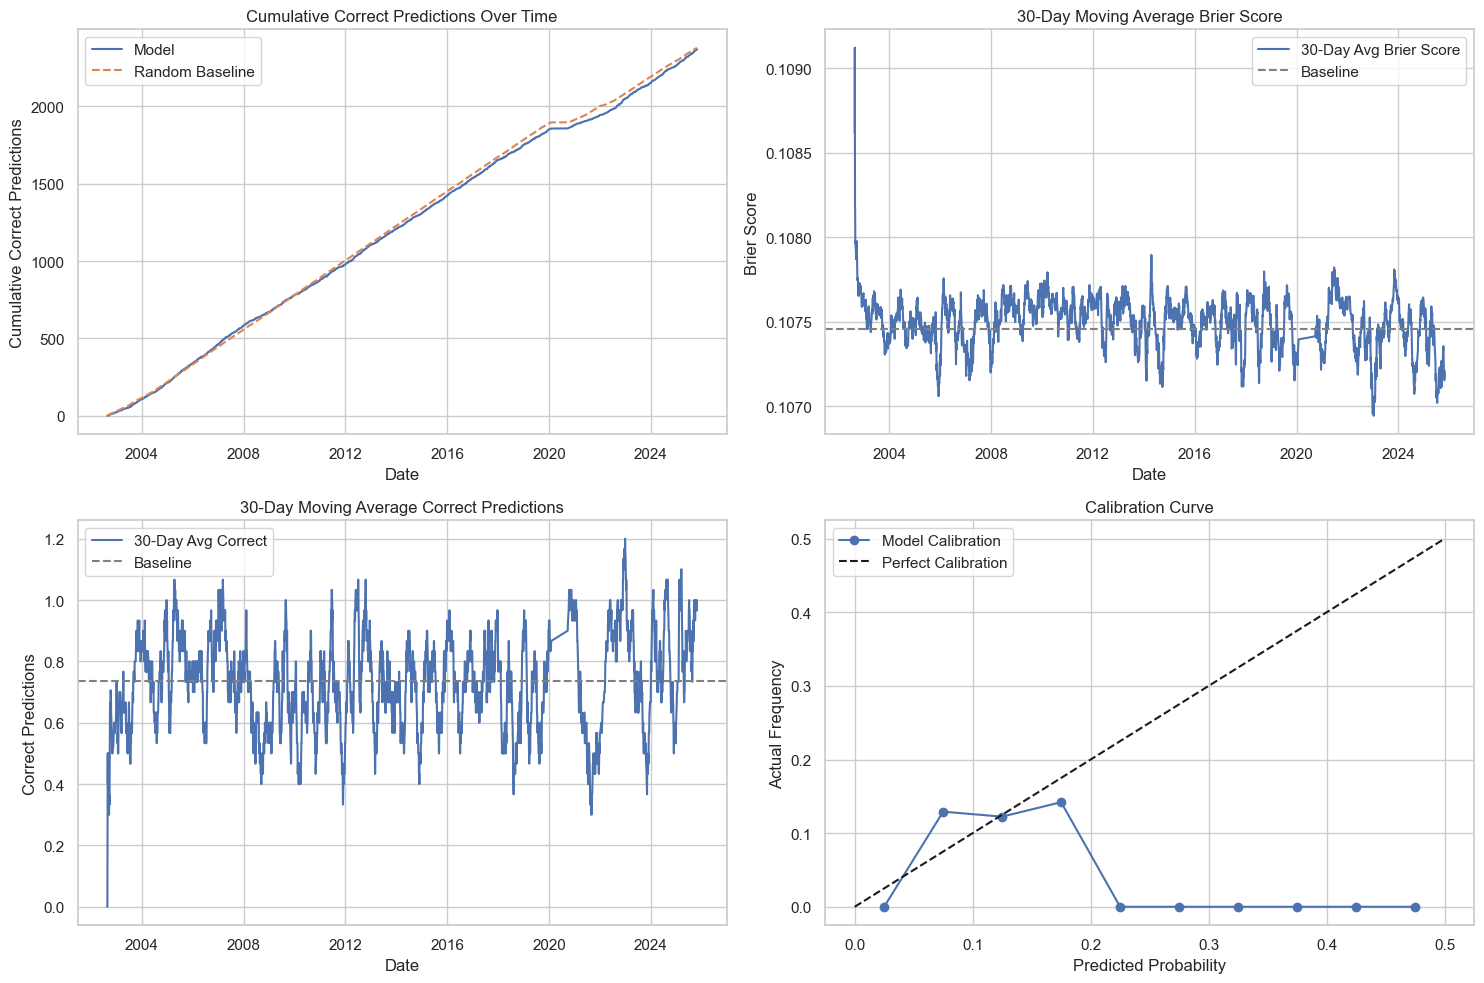

In [7]:
evaluate_model(draw_records, ball_number_color_mapping, window_size=21)

Average Brier Score: 0.1075 (Baseline: 0.1075)
Average Log-Loss: 0.3718 (Baseline: 0.3718)
Average Correct Predictions: 0.7462 (Baseline: 0.7347)


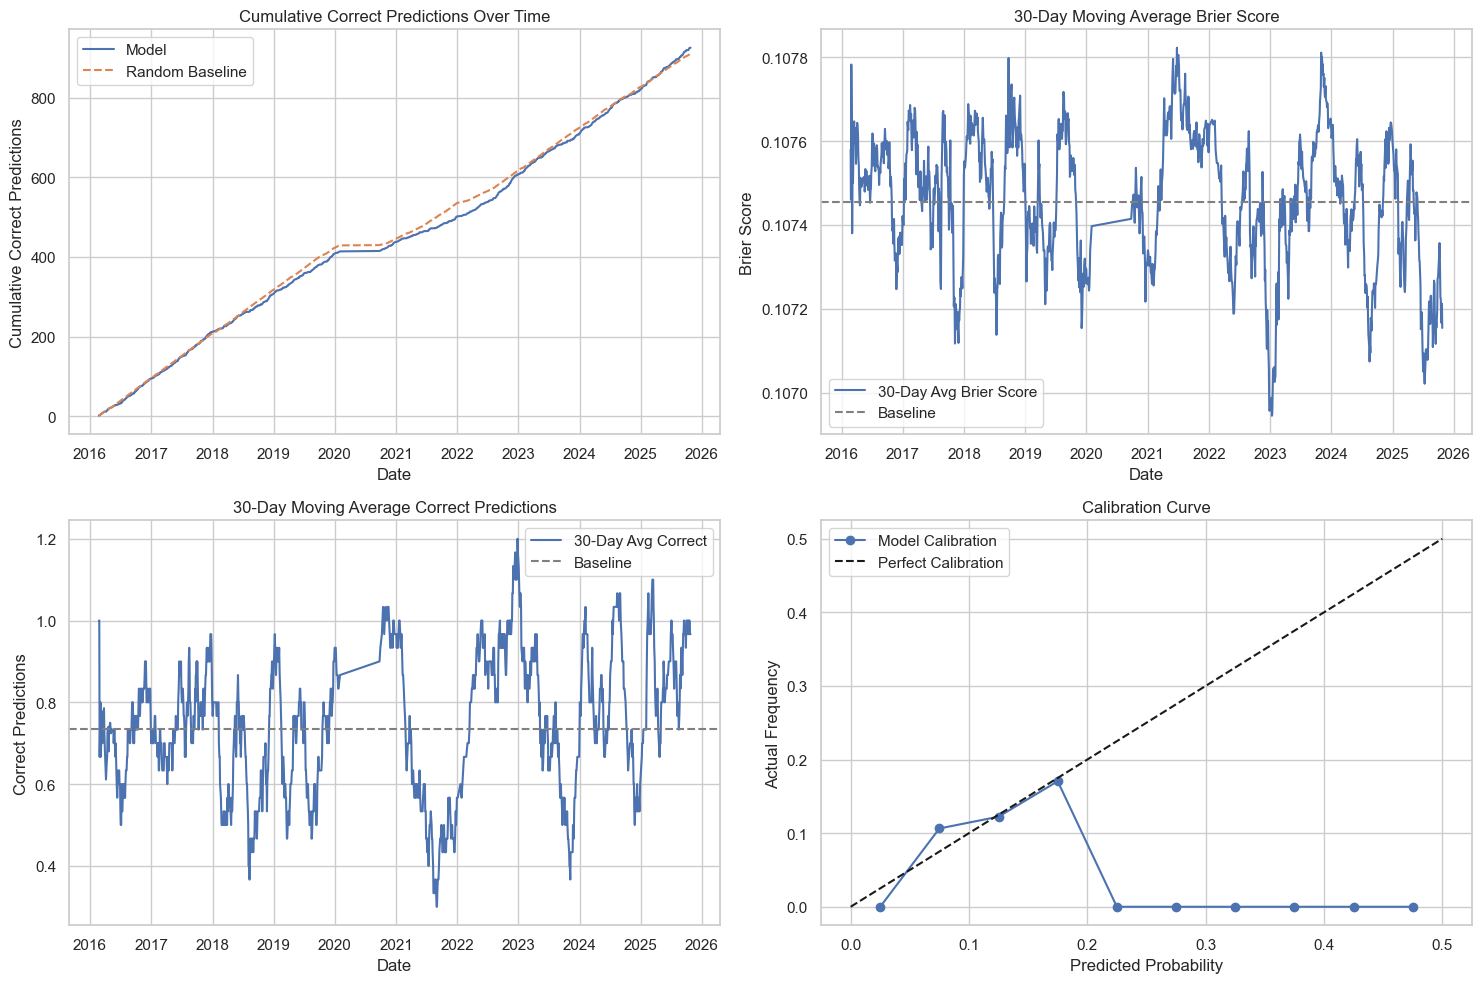

In [8]:
# Test the model on data after 2016
records_after_2016 = {date: nums for date, nums in draw_records.items() if date >= '2016-01-01'}
evaluate_model(records_after_2016, ball_number_color_mapping, window_size=21)

## 6. 📈 Results and Interpretation

- **Cumulative Correct Predictions:** If the model's line is above the baseline, it outperforms random guessing.
- **Moving Averages:** Stable or improving Brier Score and correct predictions indicate consistent performance.
- **Calibration:** Points near the diagonal show reliable probability estimates.

### **Summary**

- The hierarchical EKF model incorporates both color and number information, adapting dynamically to new data.
- Evaluation over 23 years of data shows whether the model captures patterns beyond randomness.
- Further tuning and analysis (e.g., autocorrelation, extra number modeling) can enhance insights.

> **Disclaimer:** This analysis is for educational and research purposes. Lottery draws are designed to be random, and no model can guarantee future outcomes.